## Basic Steps

1. Run a baseline training script to build a speech commands model.
2. Add in your custom word to the training and test/validation sets.
   - Modify labels, shape of your output tensor in the model.
   - Make sure that feature extractor for the model aligns with the feature extractor 
     used in the arduino code.
3. Re-train model. => TF Model using floating-point numbers, that recognizes Google word and custom word.
4. Quantize the model and convert to TFlite. => keyword_model.tflite file
5. Convert tflite to .c file, using xxd => model_data.cc
6. Replace contents of existing micro_features_model.cpp with output of xxd.

All of the above steps are done in this notebook for the commands 'left', 'right'.

7. In micro_speech.ino, modify micro_op_resolver (around line 80) to add any necessary operations (DIFF_FROM_LECTURE)
8. In micro_features_model_settings.h, modify kSilenceIndex and kUnknownIndex, depending on 
where you have them in commands.  
  - Commands = ['left', 'right', '_silence', '_unknown'] => kSilenceIndex=2, kUnknownIndex=3
9. In micro_features_model_settings.cpp, modify kCategoryLabels to correspond to commands in this script.
10. In micro_features_micro_model_settings.h, set kFeatureSliceDurationMs, kFeatureSliceStrideMs to match what is passed to microfrontend as window_size, window_step, respectively.
11. Rebuild Arduino program, run it, recognize the two target words.
12. Experiment with model architecture, training parameters/methods, augmentation, more data-gathering, etc.

*Note*:  As of 5/3/21, this model uses 22% of flash and 49.5% of RAM, so there is substantial space to improve the model, but the latency is about 208ms, which is probably too slow.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import Input, layers
from tensorflow.keras import models
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import itertools

from tqdm.notebook import tqdm
# from tqdm import tqdm # replace with this if moving out of notebook

import os
import pathlib

from datetime import datetime as dt

from IPython import display

2.12.0


In [2]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
i16min = -2**15
i16max = 2**15-1
fsamp = 16000
wave_length_ms = 1100 
wave_length_samps = int(wave_length_ms*fsamp/1000)
window_size_ms=60
window_step_ms=40
num_filters = 32
use_microfrontend = True
# dataset = 'mini-speech'
# dataset = 'full-speech-ds' # use the full speech commands as a pre-built TF dataset 
###dataset = 'full-speech-files' 
#dataset = 'dataFolder'

###silence_str = "_silence"  
#unknown_str = "Nontarget"
#EPOCHS = 25

#Audio Functions

In [4]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [5]:
def get_spectrogram(waveform):
  # Concatenate audio with padding so that all audio clips will be of the 
  # same length (16000 samples)
  zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.int16)
  waveform = tf.cast(0.5*waveform*(i16max-i16min), tf.int16)  # scale float [-1,+1]=>INT16
  equal_length = tf.concat([waveform, zero_padding], 0)
  ## Make sure these labels correspond to those used in micro_features_micro_features_generator.cpp
  spectrogram = frontend_op.audio_microfrontend(equal_length, sample_rate=fsamp, num_channels=num_filters,
                                    window_size=window_size_ms, window_step=window_step_ms)
  return spectrogram

#Gather Training X Data

In [28]:
data_dir = 'trainFolder'
trainWaves = []
trainLabels = []
trainSpecs = []

for folder in os.listdir(data_dir):            #use fewer prints when using whole dataset
  folderPath = os.path.join(data_dir, folder)
  print(folderPath)
  for file in os.listdir(folderPath):
    filePath = os.path.join(folderPath, file) 
    if '.ipynb' not in filePath:
      audio_binary = tf.io.read_file(filePath)
      waveform = decode_audio(audio_binary)
      spectrogram = get_spectrogram(waveform)
      spectrogram = tf.expand_dims(spectrogram, axis=-1)

    #print(waveform)

    if 'Train' in folderPath:
      
      if 'Gizmo' in folderPath:
        print('Gizmo:', file)
        print(waveform.shape)
        trainWaves.append(waveform)
        trainLabels.append(2)      
        trainSpecs.append(spectrogram)
      elif 'Seven' in folderPath:
        print('Seven:', file)
        print(waveform.shape)
        trainWaves.append(waveform)
        trainLabels.append(1)
        trainSpecs.append(spectrogram)
      else:
        print('Nontarget:', file)
        print(waveform.shape)
        trainWaves.append(waveform)
        trainLabels.append(0)
        trainSpecs.append(spectrogram)
    
print("Training set size:", len(trainSpecs))


trainFolder/Nontarget Train
Nontarget: nontarget_065.wav
(16896,)
Nontarget: nontarget_083.wav
(11703,)
Nontarget: nontarget_031(1).wav
(16896,)
Nontarget: nontarget_104.wav
(10449,)
Nontarget: nontarget_024.wav
(16896,)
Nontarget: 31601aad_nohash_0.wav
(10922,)
Nontarget: nontarget_067.wav
(16318,)
Nontarget: 32561e9e_nohash_0.wav
(16000,)
Nontarget: nontarget_107.wav
(10449,)
Nontarget: nontarget_109.wav
(12539,)
Nontarget: nontarget_029.wav
(16896,)
Nontarget: nontarget_027.wav
(16896,)
Nontarget: nontarget_012.wav
(13375,)
Nontarget: nontarget_013.wav
(16896,)
Nontarget: nontarget_008.wav
(12539,)
Nontarget: nontarget_007.wav
(16301,)
Nontarget: nontarget_090.wav
(7941,)
Nontarget: 234d6a48_nohash_1.wav
(16000,)
Nontarget: 30802c5d_nohash_0.wav
(16000,)
Nontarget: 24ad3ebe_nohash_0.wav
(16000,)
Nontarget: nontarget_062.wav
(16896,)
Nontarget: 234d6a48_nohash_2.wav
(16000,)
Nontarget: nontarget_036.wav
(16896,)
Nontarget: 234d6a48_nohash_3.wav
(16000,)
Nontarget: nontarget_064.wav
(

In [29]:
### THIS is our X data, the spectrograms ###

trainSpecs[0].shape

TensorShape([27, 32, 1])

Now shuffle the Training X data

In [30]:
trainSpecsShuf, trainLabelsShuf = sklearn.utils.shuffle(trainSpecs, trainLabels)
#for label, spec in zip(trainLabelsShuf, trainSpecsShuf):
#  print("Label:", label, "  Size:", len(spec))

In [31]:
trainSpecsNP = np.copy(trainSpecsShuf)
print("Length:", len(trainSpecsNP))
type(trainSpecsNP)

Length: 398


numpy.ndarray

In [32]:
trainLabelsNP = np.copy(trainLabelsShuf)
print("Length:", len(trainLabelsNP))
type(trainLabelsNP)

Length: 398


numpy.ndarray

#Now collect Validation X data

In [33]:
data_dir = 'valFolder'
valWaves = []
valLabels = []
valSpecs = []

for folder in os.listdir(data_dir):            #use fewer prints when using whole dataset
  folderPath = os.path.join(data_dir, folder)
  print(folderPath)
  for file in os.listdir(folderPath):
    filePath = os.path.join(folderPath, file) 
    if '.ipynb' not in filePath:
      audio_binary = tf.io.read_file(filePath)
      waveform = decode_audio(audio_binary)
      spectrogram = get_spectrogram(waveform)
      spectrogram = tf.expand_dims(spectrogram, axis=-1)
    #print(waveform)

    if 'Val' in folderPath:
      
      if 'Gizmo' in folderPath:
        print('Gizmo:', file)
        print(waveform.shape)
        valWaves.append(waveform)
        valLabels.append(2)   
        valSpecs.append(spectrogram)  
      elif 'Seven' in folderPath:
        print('Seven:', file)
        print(waveform.shape)
        valWaves.append(waveform)
        valLabels.append(1)
        valSpecs.append(spectrogram)  
      else:
        print('Nontarget:', file)
        print(waveform.shape)
        valWaves.append(waveform)
        valLabels.append(0)
        valSpecs.append(spectrogram)  
    
print("Validation set size:", len(valSpecs))

valFolder/Nontarget Val
Nontarget: nontarget_val_05.wav
(16896,)
Nontarget: nontarget_val_03.wav
(16896,)
Nontarget: nontarget_val_11.wav
(16896,)
Nontarget: nontarget_val_08.wav
(16896,)
Nontarget: nontarget_val_15.wav
(16896,)
Nontarget: nontarget_val_23.wav
(16896,)
Nontarget: nontarget_val_22.wav
(16896,)
Nontarget: nontarget_val_19.wav
(16896,)
Nontarget: nontarget_val_13.wav
(16896,)
Nontarget: nontarget_val_20.wav
(16896,)
Nontarget: nontarget_val_01.wav
(16896,)
Nontarget: nontarget_val_07.wav
(16896,)
Nontarget: nontarget_val_18.wav
(16896,)
Nontarget: nontarget_val_14.wav
(16896,)
Nontarget: nontarget_val_02.wav
(16896,)
Nontarget: nontarget_val_25.wav
(16896,)
Nontarget: nontarget_val_06.wav
(16896,)
Nontarget: nontarget_val_10.wav
(16896,)
Nontarget: nontarget_val_04.wav
(16896,)
Nontarget: nontarget_val_12.wav
(16896,)
Nontarget: nontarget_val_17.wav
(16896,)
Nontarget: nontarget_val_24.wav
(16896,)
Nontarget: nontarget_val_21.wav
(16896,)
Nontarget: nontarget_val_26.wav
(

In [34]:
valSpecs[0].shape

TensorShape([27, 32, 1])

In [35]:
valSpecsShuf, valLabelsShuf = sklearn.utils.shuffle(valSpecs, valLabels)

In [36]:
valSpecsNP = np.copy(valSpecsShuf)
print("Length:", len(valSpecsNP))
type(valSpecsNP)

Length: 68


numpy.ndarray

In [37]:
valLabelsNP = np.copy(valLabelsShuf)
print("Length:", len(valLabelsNP))
type(valLabelsNP)

Length: 68


numpy.ndarray

#Model Architecture

In [50]:
input_shape = (27,32,1)

print('Input shape:', input_shape)
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(name='pool2'),
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),
    layers.Conv2D(64, 1, activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPooling2D(pool_size=(4,4)),
    layers.Conv2D(32, 1, activation='relu'),
    layers.Dropout(0.2),

    #classifier
    layers.Flatten(),
    layers.Dense(128, activation='relu'), #change to 64?
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'), #change to 64?
    layers.Dropout(0.2),
    layers.Dense(3),   #Jac: remember to change to 3
], name="modified_cnn")

model.summary()

Input shape: (27, 32, 1)
Model: "modified_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 25, 30, 32)        320       
                                                                 
 pool2 (MaxPooling2D)        (None, 12, 15, 32)        0         
                                                                 
 depthwise_conv2d_2 (Depthwi  (None, 12, 15, 32)       320       
 seConv2D)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 15, 64)        2112      
                                                                 
 dropout_6 (Dropout)         (None, 12, 15, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0         
 2D)                         

In [51]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy'],
)

In [40]:
#  Google: feature extraction with Keras
# feature_model = tf.keras.model(input=model.input, output= model.layers[4].output)

In [52]:
history = model.fit(
    trainSpecsNP, 
    trainLabelsNP,
    validation_data=(valSpecsNP, valLabelsNP),  
    epochs=30) 
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))

Epoch 1/30
13/13 [==============================] - 2s 49ms/step - loss: 4.7024 - accuracy: 0.3492 - val_loss: 1.0660 - val_accuracy: 0.4853
Epoch 2/30
13/13 [==============================] - 1s 52ms/step - loss: 1.8109 - accuracy: 0.3894 - val_loss: 0.9559 - val_accuracy: 0.5000
Epoch 3/30
13/13 [==============================] - 1s 54ms/step - loss: 1.2702 - accuracy: 0.4246 - val_loss: 0.9298 - val_accuracy: 0.5882
Epoch 4/30
13/13 [==============================] - 1s 56ms/step - loss: 1.0907 - accuracy: 0.4673 - val_loss: 0.9513 - val_accuracy: 0.5735
Epoch 5/30
13/13 [==============================] - 1s 55ms/step - loss: 1.0053 - accuracy: 0.5226 - val_loss: 0.9216 - val_accuracy: 0.6029
Epoch 6/30
13/13 [==============================] - 1s 44ms/step - loss: 0.9799 - accuracy: 0.5251 - val_loss: 0.8873 - val_accuracy: 0.6618
Epoch 7/30
13/13 [==============================] - 0s 35ms/step - loss: 0.9337 - accuracy: 0.5905 - val_loss: 0.8684 - val_accuracy: 0.6765
Epoch 8/30
13

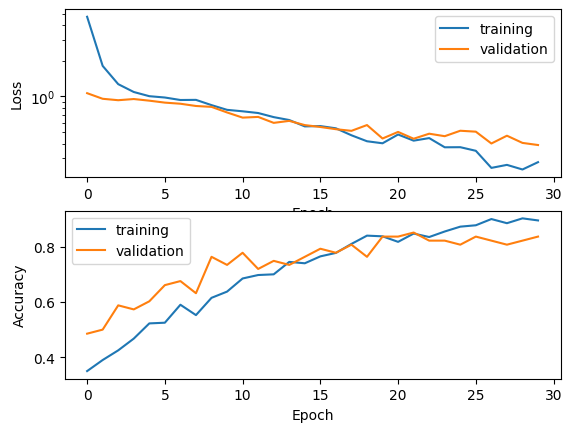

In [53]:
metrics = history.history
plt.subplot(2,1,1)
plt.semilogy(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(2,1,2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [97]:
data_dir = 'testFolder'
testWaves = []
testLabels = []
testSpecs = []

for folder in os.listdir(data_dir):            #use fewer prints when using whole dataset
  folderPath = os.path.join(data_dir, folder)
  print(folderPath)
  for file in os.listdir(folderPath):
    filePath = os.path.join(folderPath, file) 
    if '.ipynb' not in filePath:
      audio_binary = tf.io.read_file(filePath)
      waveform = decode_audio(audio_binary)
      spectrogram = get_spectrogram(waveform)
      spectrogram = tf.expand_dims(spectrogram, axis=-1)
    #print(waveform)

    if 'Test' in folderPath:
      
      if 'Gizmo' in folderPath:
        print('Gizmo:', file)
        print(waveform.shape)
        testWaves.append(waveform)
        testLabels.append(2)   
        testSpecs.append(spectrogram)  
      elif 'Seven' in folderPath:
        print('Seven:', file)
        print(waveform.shape)
        testWaves.append(waveform)
        testLabels.append(1)
        testSpecs.append(spectrogram)  
      else:
        print('Nontarget:', file)
        print(waveform.shape)
        testWaves.append(waveform)
        testLabels.append(0)
        testSpecs.append(spectrogram)  
    
print("Test set size:", len(testSpecs))

testFolder2/Seven Test
Seven: 6c0f6493_nohash_1.wav
(16000,)
Seven: 6ac35824_nohash_0.wav
(16000,)
Seven: 6ace4fe1_nohash_0.wav
(16000,)
Seven: 6add0595_nohash_0.wav
(16000,)
Seven: 6af4aa07_nohash_0.wav
(16000,)
Seven: 6b7d5101_nohash_0.wav
(16000,)
Seven: 6bf5baf3_nohash_1.wav
(16000,)
Seven: 6add0595_nohash_1.wav
(16000,)
Seven: 6bf5baf3_nohash_0.wav
(16000,)
Seven: 6c0f6493_nohash_3.wav
(16000,)
Seven: 6c0f6493_nohash_2.wav
(16000,)
Seven: 6c0f6493_nohash_0.wav
(16000,)
Seven: 6aafb34f_nohash_0.wav
(16000,)
Seven: 6af4aa07_nohash_2.wav
(16000,)
Seven: 6ace4fe1_nohash_2.wav
(16000,)
Seven: 6bf5baf3_nohash_4.wav
(16000,)
Seven: 6af4aa07_nohash_1.wav
(16000,)
Seven: 6ace4fe1_nohash_1.wav
(16000,)
Seven: 6aa8def4_nohash_4.wav
(16000,)
Seven: 6bf5baf3_nohash_2.wav
(16000,)
Seven: 6b81fead_nohash_0.wav
(16000,)
Seven: 6bf5baf3_nohash_3.wav
(16000,)
Seven: 6bd4554d_nohash_0.wav
(11888,)
testFolder2/Nontarget Test
Nontarget: 31601aad_nohash_0.wav
(10922,)
Nontarget: 32561e9e_nohash_0.wav
(

In [98]:
testSpecs[0].shape

TensorShape([27, 32, 1])

In [99]:
testSpecsShuf, testLabelsShuf = sklearn.utils.shuffle(testSpecs, testLabels)

In [100]:
testSpecsNP = np.copy(testSpecsShuf)
print("Length:", len(testSpecsNP))
type(testSpecsNP)

Length: 68


numpy.ndarray

In [101]:
testLabelsNP = np.copy(testLabelsShuf)
print("Length:", len(testLabelsNP))
type(testLabelsNP)

Length: 68


numpy.ndarray

In [102]:
y_pred = np.argmax(model.predict(testSpecsNP), axis=1)
y_true = testLabelsNP

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

3/3 [==============================] - 0s 7ms/step
Test set accuracy: 85%


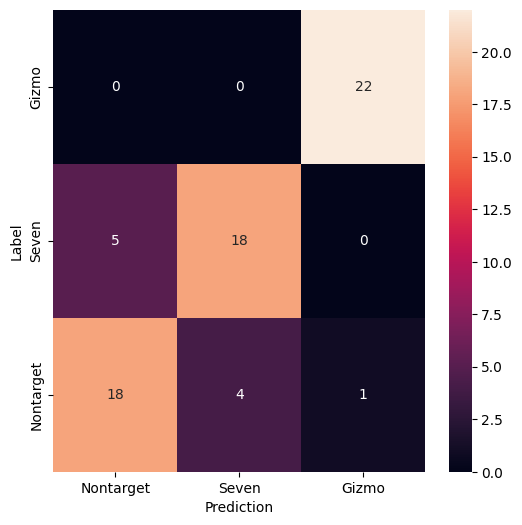

In [103]:
label_list = ['Nontarget', 'Seven', 'Gizmo']

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Quantize and Convert to TFLite

In [70]:
def representative_dataset():
  for _ in range(100):
    data = np.random.rand(1, 27, 32, 1)
    yield [data.astype(np.float32)]

In [71]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8 # or tf.uint8
converter.inference_output_type = tf.int8 # or tf.uint8
tflite_quant_model = converter.convert()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [72]:
# Save the model
with open('model1.tflite', 'wb') as f:
  f.write(tflite_quant_model)